In [1]:
%matplotlib inline
import datacube
import sys
import math
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.plotting import rgb
#from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map

In [1]:
dc = datacube.Datacube(app="ls8_sr")

NameError: name 'datacube' is not defined

In [ ]:
productA = "ls8_sr"
measurements = dc.list_measurements()
measurements.loc[productA]

In [2]:
# Setting the query for area in the proximity of Cairo
lon = (51.531, 53.587)
lat = (11.964, 14.054)

query = {
    "x": lon,
    "y": lat,
    "time": ("2023-01-19 06:50:03", "2023-01-19 06:50:03")
}

display_map(x=lon, y=lat)


NameError: name 'display_map' is not defined

In [3]:
datasets = dc.find_datasets(product='ls8_sr')

datasets

NameError: name 'dc' is not defined

In [4]:
bands = ['SR_B1'] 
ds_ls8_sr = dc.load(
    product='ls8_sr', 
    output_crs="EPSG:32639", 
    resolution=(-250, 250), 
    measurements=bands,
    **query
) 
ds_ls8_sr

NameError: name 'dc' is not defined

In [5]:
ds = dc.load(product="ls8_sr",
             measurements=['red', 'green', 'blue'],
             output_crs="EPSG:32639", 
             resolution=(-250, 250), 
             **query
             )

print(ds)

NameError: name 'dc' is not defined

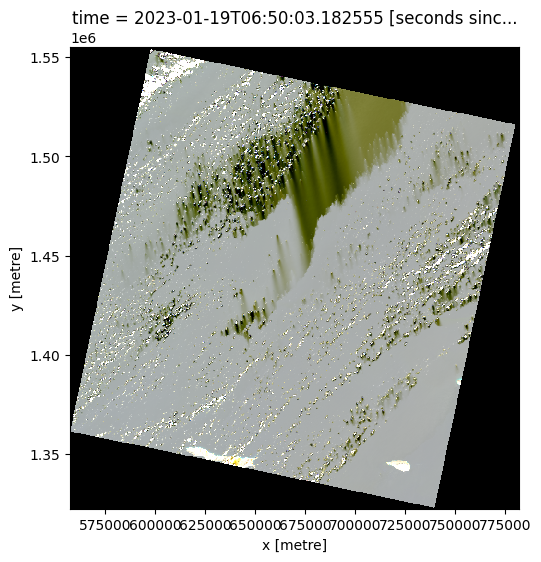

In [7]:
rgb(ds, index=0)

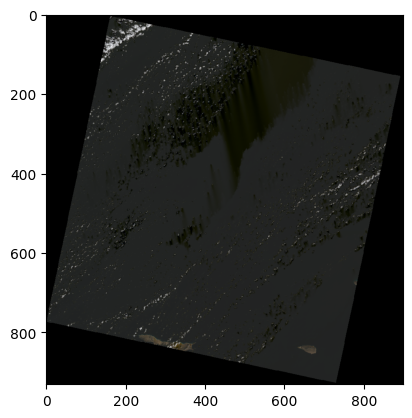

In [8]:
# Chọn thời điểm đầu tiên
time_index = 0

# Lấy dữ liệu từ các band
red = ds['red'].values[time_index]
green = ds['green'].values[time_index]
blue = ds['blue'].values[time_index]

# Chuẩn hóa dữ liệu vào khoảng [0, 1]
red_norm = red / np.max(red)
green_norm = green / np.max(green)
blue_norm = blue / np.max(blue)

# Tạo ảnh RGB từ các band đã chuẩn hóa
rgb_image = np.dstack((red_norm, green_norm, blue_norm))

# Hiển thị ảnh viễn thám
plt.imshow(rgb_image)
plt.show()


In [9]:
print(ds.variables)


Frozen({'time': <xarray.IndexVariable 'time' (time: 1)>
array(['2023-01-19T06:50:03.182555000'], dtype='datetime64[ns]')
Attributes:
    units:    seconds since 1970-01-01 00:00:00, 'y': <xarray.IndexVariable 'y' (y: 931)>
array([1555125., 1554875., 1554625., ..., 1323125., 1322875., 1322625.])
Attributes:
    units:       metre
    resolution:  -250.0
    crs:         epsg:32639, 'x': <xarray.IndexVariable 'x' (x: 898)>
array([557375., 557625., 557875., ..., 781125., 781375., 781625.])
Attributes:
    units:       metre
    resolution:  250.0
    crs:         epsg:32639, 'spatial_ref': <xarray.Variable ()>
array(32639)
Attributes:
    spatial_ref:        PROJCS["WGS 84 / UTM zone 39N",GEOGCS["WGS 84",DATUM[...
    grid_mapping_name:  transverse_mercator, 'red': <xarray.Variable (time: 1, y: 931, x: 898)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
     

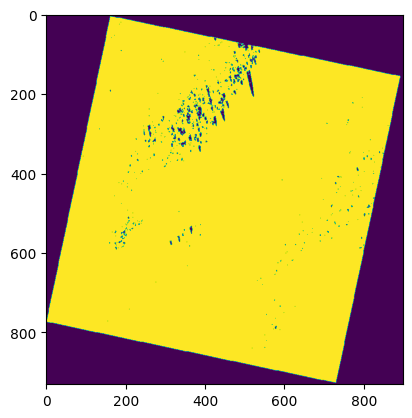

In [12]:
# Test Threshold
ds = dc.load(product="ls8_sr",
             measurements=['red', 'green', 'blue'],
             output_crs="EPSG:32639", 
             resolution=(-250, 250), 
             **query)

# Chọn thời điểm đầu tiên
time_index = 0

# Lấy dữ liệu từ các band
red = ds['red'].isel(time=time_index).values
green = ds['green'].isel(time=time_index).values
blue = ds['blue'].isel(time=time_index).values

# Tạo một mảng chứa dữ liệu đặc trưng (tổ hợp các band)
features = np.dstack((red, green, blue))

# Phân tích dữ liệu và xác định vùng trồng cây
# ... Thực hiện các bước phân tích và xác định vùng trồng cây tại đây ...
# Ví dụ: Một phân đoạn đơn giản bằng cách đặt ngưỡng trên dữ liệu red
threshold = 1000
prediction = np.where(red > threshold, 1, 0)

# Hiển thị kết quả
plt.imshow(prediction, cmap='viridis')
plt.show()

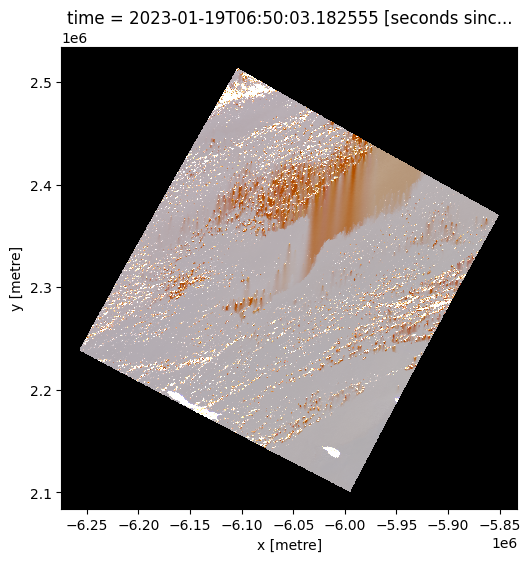

In [14]:
ds = dc.load(product="ls8_sr",
             measurements=['red', 'green', 'blue', 'swir_1', 'nir'],
             output_crs="EPSG:32648", 
             resolution=(-250, 250), 
             **query
             )

rgb(ds, bands=['swir_1', 'nir', 'green'], index=0)

D:\Tools\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


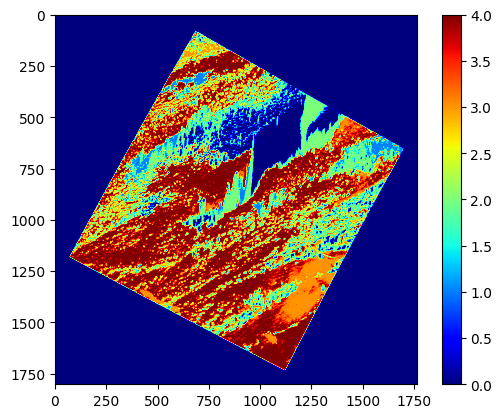

In [15]:
# Test KMeans
ds = dc.load(product="ls8_sr",
             measurements=['red', 'green', 'blue', 'swir_1', 'nir'],
             output_crs="EPSG:32648", 
             resolution=(-250, 250), 
             **query
             )

# Chuyển đổi dữ liệu sang định dạng phù hợp
data = ds[['red', 'green', 'blue', 'swir_1', 'nir']].to_array().transpose('time', 'y', 'x', 'variable')
data = data.astype('float32') / 10000.0  # Chuẩn hóa giá trị pixel về khoảng từ 0 đến 1

from skimage import exposure, measure

# Tạo ảnh RGB từ dữ liệu
rgb_image = np.stack([data.sel(variable='red'), data.sel(variable='green'), data.sel(variable='blue')], axis=-1)

# Cân bằng histogram cho ảnh RGB
rgb_image_eq = exposure.equalize_hist(rgb_image)

# Áp dụng thuật toán phân đoạn, ví dụ: K-means clustering
from sklearn.cluster import KMeans

# Chuyển đổi ảnh thành vector dữ liệu để áp dụng K-means
height, width = rgb_image_eq.shape[1:3]  # Lấy kích thước ảnh (640, 895)
rgb_image_eq_reshaped = rgb_image_eq.reshape((height * width, 3))

# Áp dụng K-means clustering với số lượng cụm tùy chọn
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(rgb_image_eq_reshaped)

# Gán nhãn cho từng điểm ảnh
labels = kmeans.labels_.reshape((height, width))

# Hiển thị ảnh phân đoạn
plt.imshow(labels, cmap='jet')
plt.colorbar()
plt.show()
